<a href="https://colab.research.google.com/github/HosnawHb/Decision-Tree-Classifier/blob/main/CA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Pre Process

## Loading Data

In [6]:
url = 'https://raw.githubusercontent.com/amirkasaei/Decision-Tree-Classifier-with-scikit-learn/main/Dataset/connect-4.data'
categorical_attr = [str(i) for i in range(1, 43)] + ['win']
df = pd.read_csv(url, names=categorical_attr)

In [7]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,win
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win


## Labeling Data

In [8]:
le = LabelEncoder()
df[categorical_attr] = df[categorical_attr].apply(le.fit_transform, axis=0)

In [9]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,win
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Splitting Data

In [10]:
X = np.array(df.iloc[:, :-1]) #selecting all columns but the last one
y = np.array(df['win'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.5, random_state=12)

# Report

## Simple Tree

In [11]:
def plot(criterion,X_train,y_train,X_test,y_test):
  tr_acc = []
  va_acc = []

  depth_list = range(1,16)

  for d in depth_list:
      model = DecisionTree(max_depth=d)
      model.fit(criterion,X_train, y_train)
      preds = model.predict(X_test)
      preds_2 = model.predict(X_train)
      tr_acc.append(accuracy_score(y_train, preds_2))
      va_acc.append(accuracy_score(y_test,preds))

  plt.figure(figsize=([9, 6]))
  plt.plot(depth_list, tr_acc, label='Training Accuracy')
  plt.plot(depth_list, va_acc, label='Validation Accuracy')
  plt.xlabel('Maximum Depth')
  plt.ylabel('Accuracy')
  plt.xticks(depth_list)
  plt.legend()
  plt.show()


## Confusion Matrix

In [27]:
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

# Decision Tree From Scratch

## Tree implementation

In [7]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [8]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self,min_samples_split=2, max_depth=15):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.

        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.

        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    def gini(self, parent, left_child, right_child):
        # Calculate the Gini impurity of a set of labels
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        return 1 - np.sum(np.square(proportions))

    def log_loss(self, parent, left_child, right_child):
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        return -np.sum(proportions * np.log2(proportions))

    def _best_split(self,criterion,X, y):
        '''
        Helper function, calculates the best split for given features and target

        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        best_log_loss = -1
        best_gini = -1
        n_rows, n_cols = X.shape

        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    if(criterion == 'entropy'):
                      gain = self._information_gain(y, y_left, y_right)
                      if gain > best_info_gain:
                          best_split = {
                              'feature_index': f_idx,
                              'threshold': threshold,
                              'df_left': df_left,
                              'df_right': df_right,
                              'gain': gain
                          }
                          best_info_gain = gain
                    elif(criterion == 'gini'):
                      gain = self.gini(y, y_left, y_right)
                      if gain > best_gini:
                          best_split = {
                              'feature_index': f_idx,
                              'threshold': threshold,
                              'df_left': df_left,
                              'df_right': df_right,
                              'gain': gain
                         }
                          best_gini = gain
                    else:
                      gain = self.log_loss(y, y_left, y_right)
                      if gain > best_log_loss:
                          best_split = {
                              'feature_index': f_idx,
                              'threshold': threshold,
                              'df_left': df_left,
                              'df_right': df_right,
                              'gain': gain
                          }
                          best_log_loss = gain
        return best_split

    def _build(self,criterion, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.

        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape

        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(criterion,X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    criterion,
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self._build(
                    criterion,
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )

    def fit(self,criterion, X, y):
        '''
        Function used to train a decision tree classifier model.

        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(criterion,X, y)

    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).

        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]

        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)

        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)

    def predict(self, X):
        '''
        Function used to classify new instances.

        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

## Entropy

### 20,80

In [38]:
model_entropy = DecisionTree()
model_entropy.fit('entropy',X_train, y_train)
preds_entropy = model_entropy.predict(X_test)
accuracy_score(y_test,preds_entropy)

0.7350503256364713

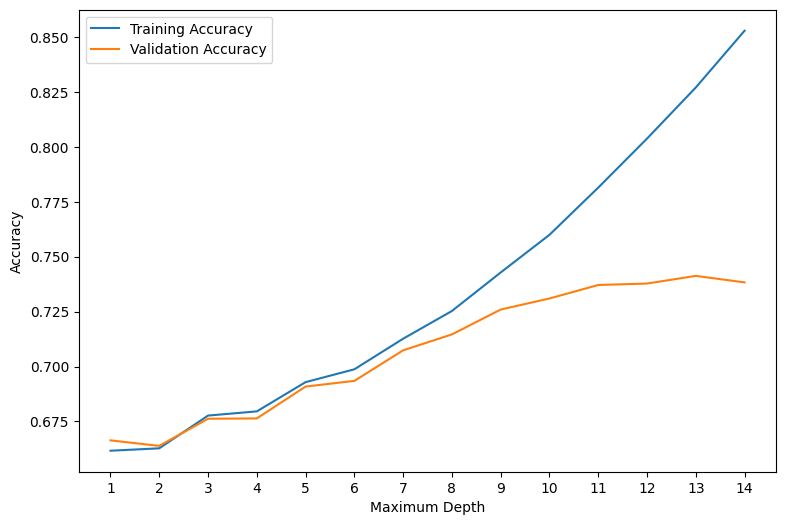

In [48]:
plot('entropy',X_train,y_train,X_test,y_test)

### 50,50

In [10]:
model_entropy_2 = DecisionTree()
model_entropy_2.fit('entropy',X_train_2, y_train_2)
preds_entropy_2 = model_entropy_2.predict(X_test_2)
accuracy_score(y_test_2,preds_entropy_2)

0.726812516652358

## Gini

### 20,80

In [11]:
model_gini = DecisionTree()
model_gini.fit('gini',X_train, y_train)
preds_gini = model_gini.predict(X_test)
accuracy_score(y_test, preds_gini)

0.7256512729425696

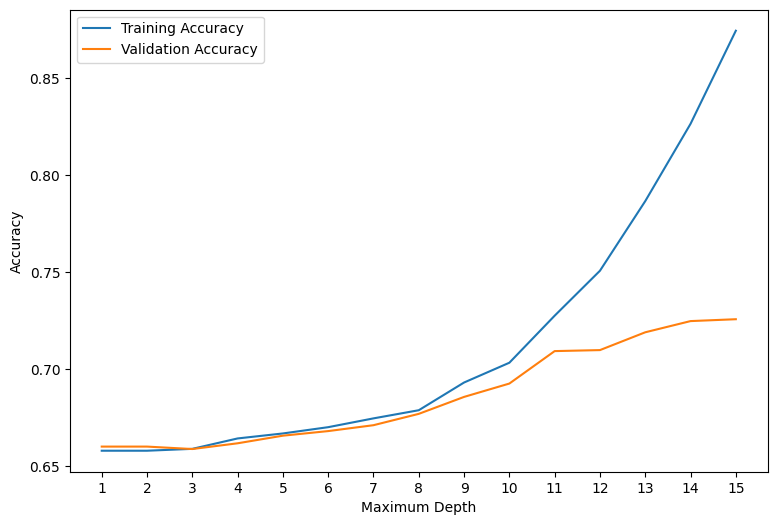

In [51]:
plot('gini',X_train,y_train,X_test,y_test)

### 50,50

In [12]:
model_gini_2 = DecisionTree()
model_gini_2.fit('gini',X_train_2, y_train_2)
preds_gini_2 = model_gini_2.predict(X_test_2)
accuracy_score(y_test_2, preds_gini_2)

0.7092572308238847

## Log Loss

### 20,80

In [13]:
model_log_loss = DecisionTree()
model_log_loss.fit('log_loss',X_train, y_train)
preds_log_loss = model_log_loss.predict(X_test)
accuracy_score(y_test,preds_log_loss)

0.7256512729425696

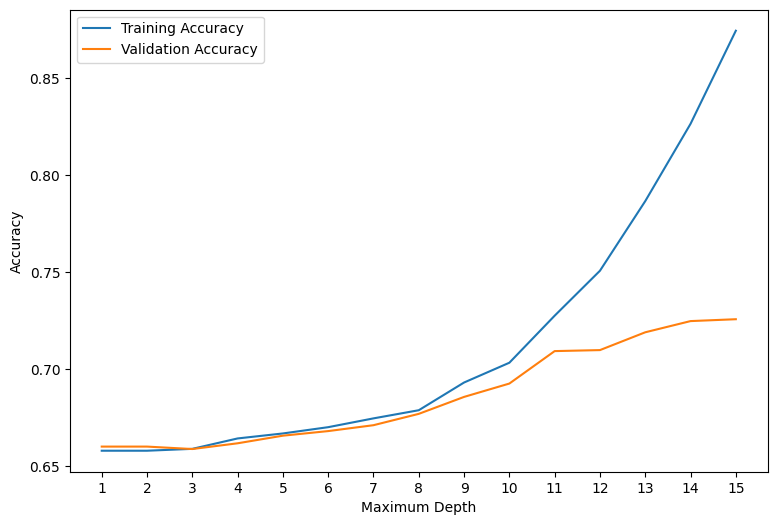

In [52]:
plot('log_loss',X_train,y_train,X_test,y_test)

In [14]:
model_log_loss_2 = DecisionTree()
model_log_loss_2.fit('log_loss',X_train_2, y_train_2)
preds_log_loss_2 = model_log_loss_2.predict(X_test_2)
accuracy_score(y_test_2,preds_log_loss_2)

0.7092572308238847

#Decision Tree Using Library


## Entropy

Tree

In [12]:
clf = tree.DecisionTreeClassifier(criterion = "entropy",min_samples_split = 12,max_depth = 15, min_samples_leaf = 9)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

Visualization

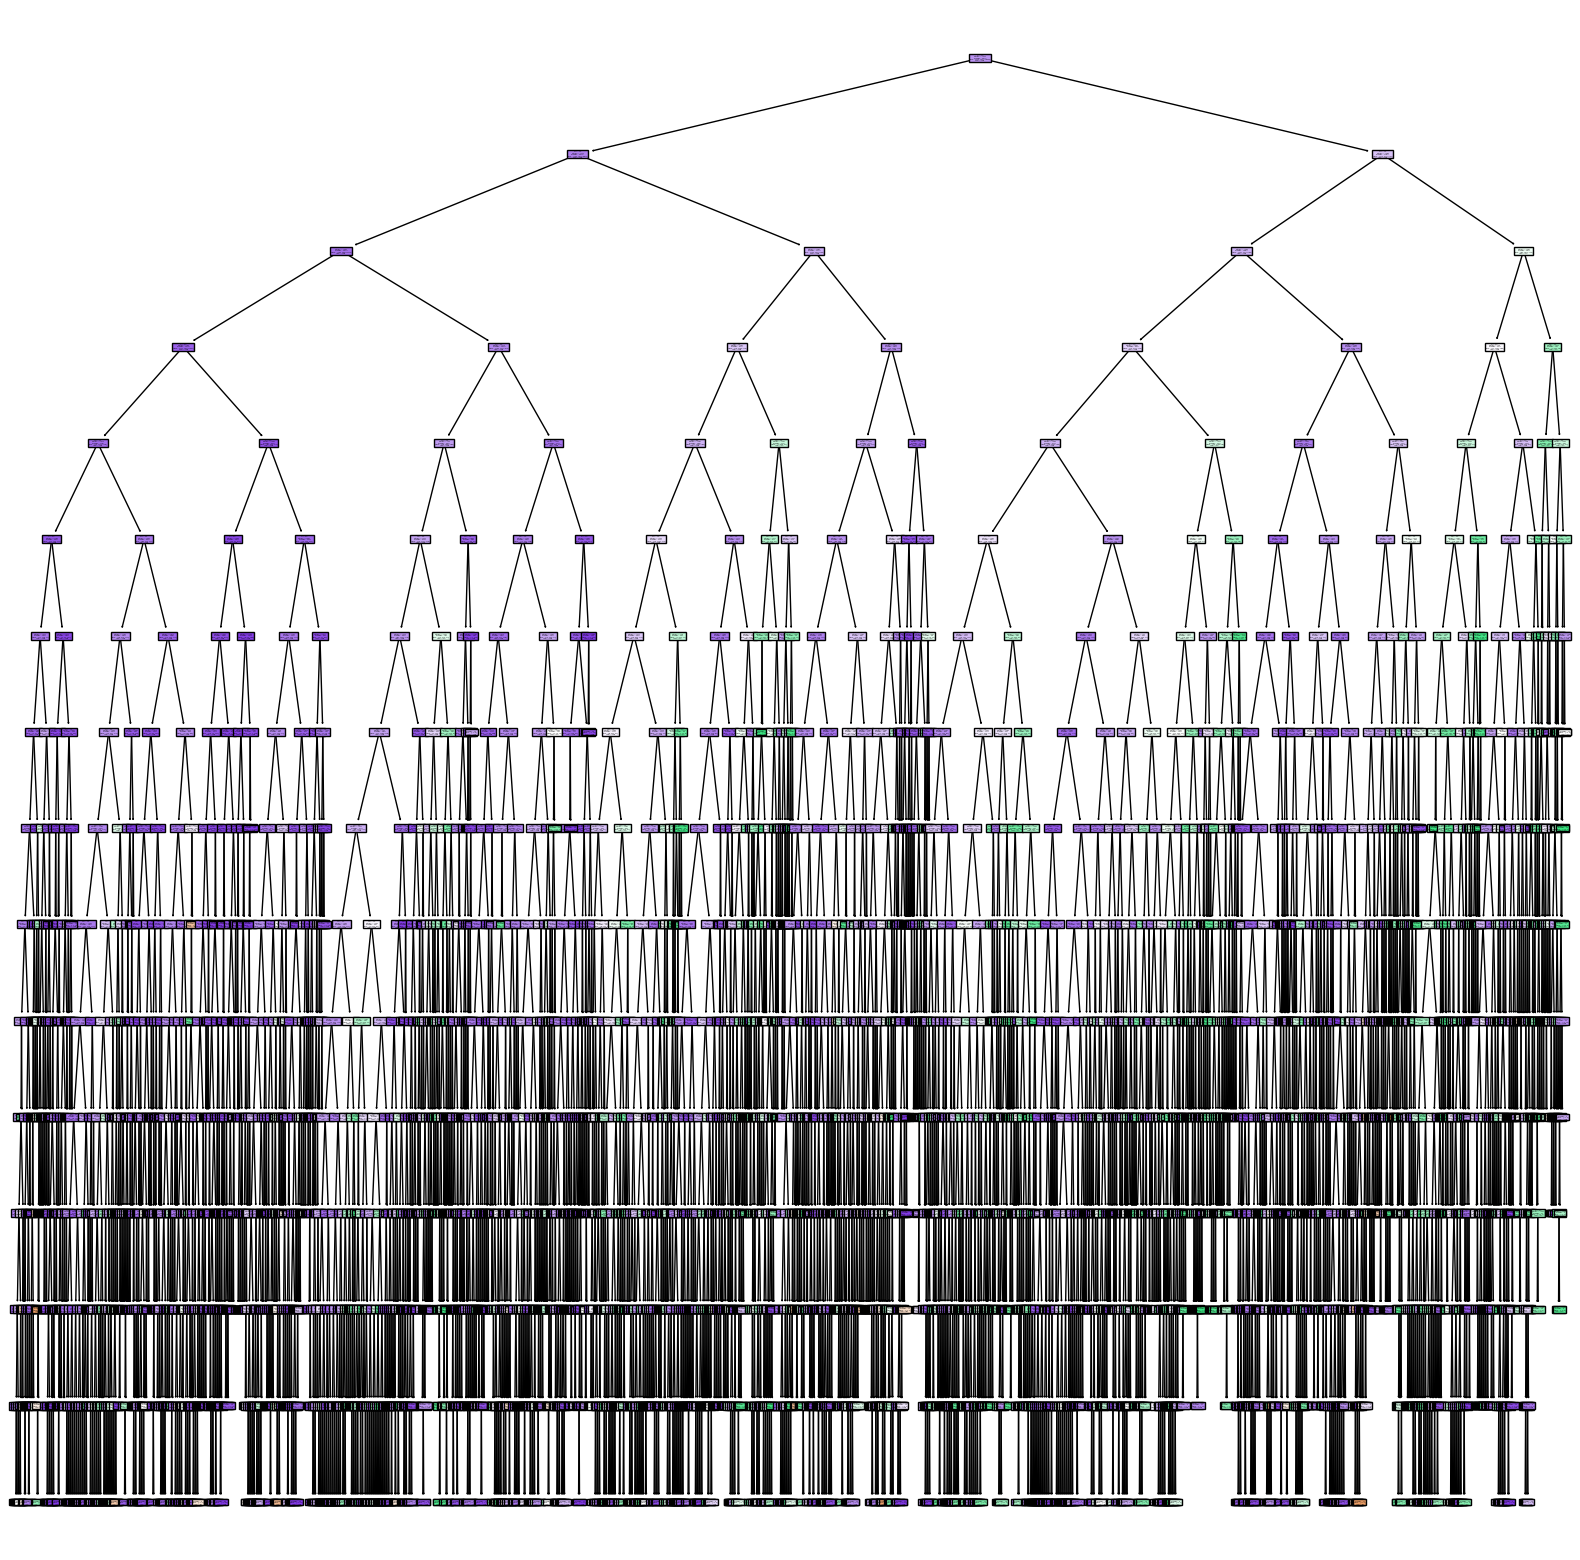

In [136]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['win','loss','draw']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

Confusion Matrix

Train score 0.7878434637801832
Test score 0.7412670219064535
Train Confusion matrix


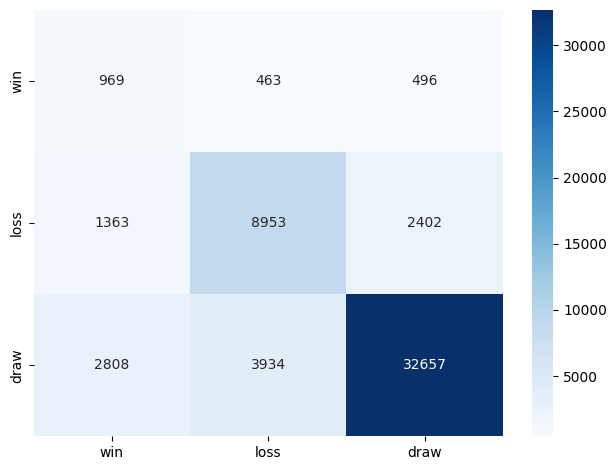

Test Confusion matrix


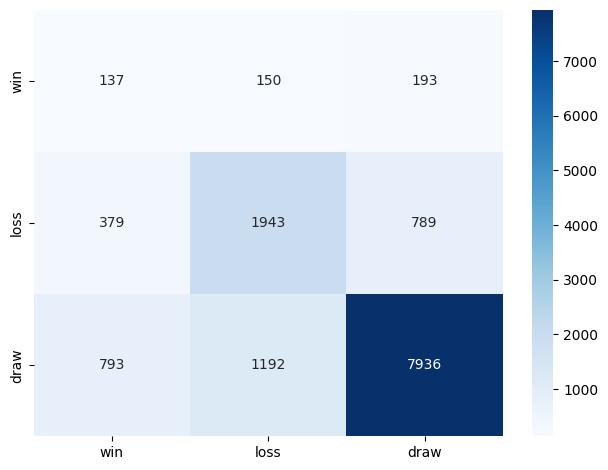

In [137]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')


## Gini

Tree

In [25]:
clf = tree.DecisionTreeClassifier(criterion = "gini",min_samples_split = 12,max_depth = 15, min_samples_leaf = 9)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

Visualization

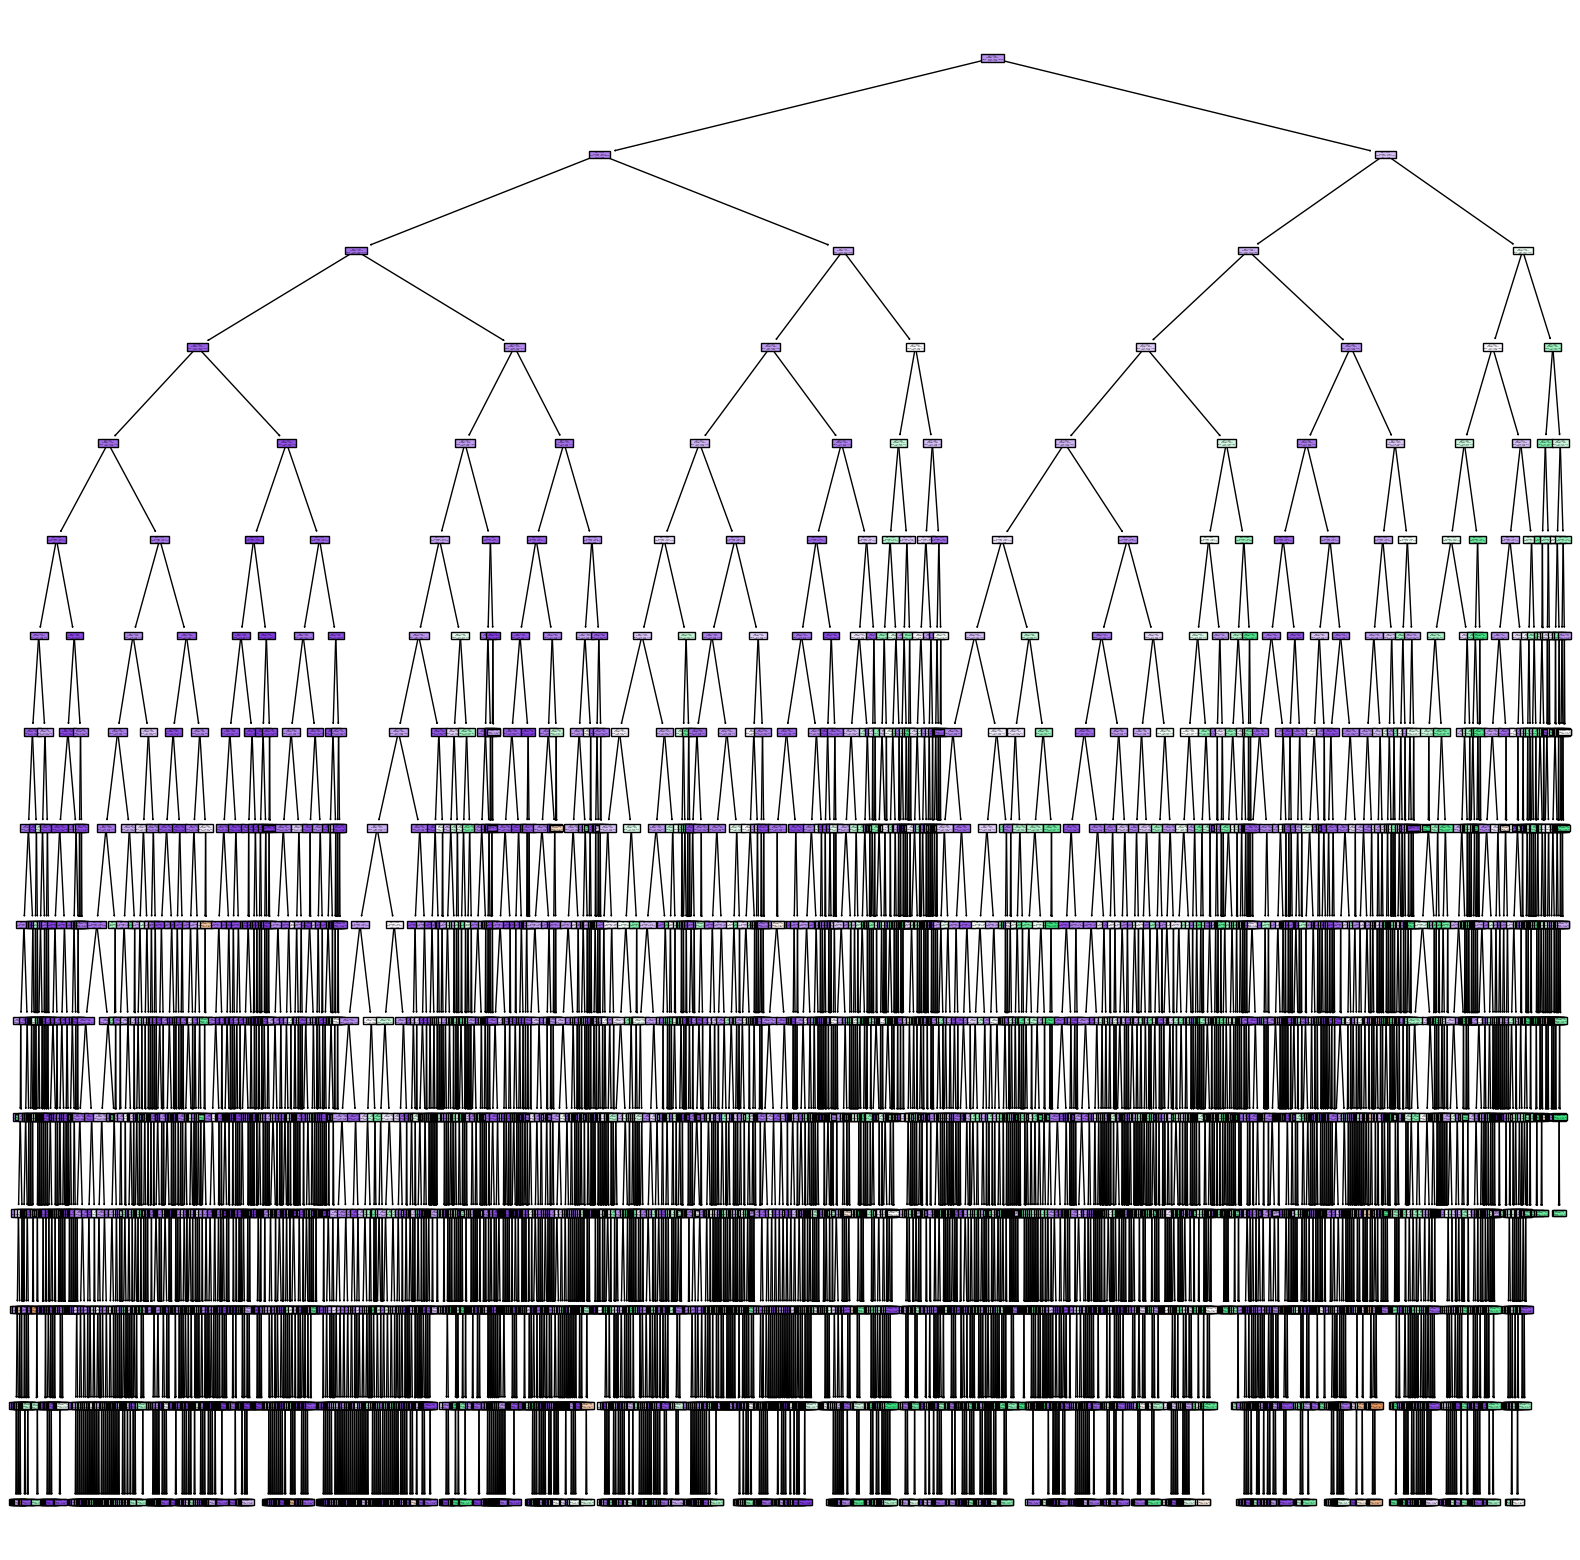

In [26]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['win','loss','draw']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

Train score 0.7903968914793228
Test score 0.7407489638839551
Train Confusion matrix


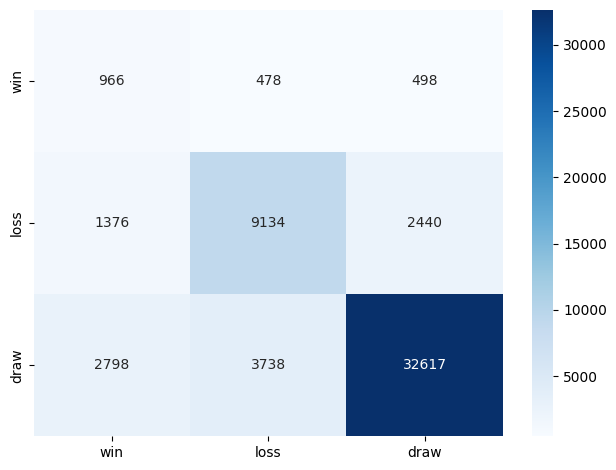

Test Confusion matrix


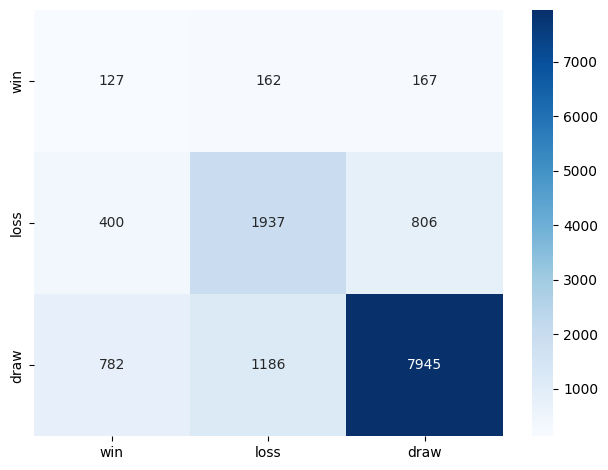

In [28]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

# Pruning

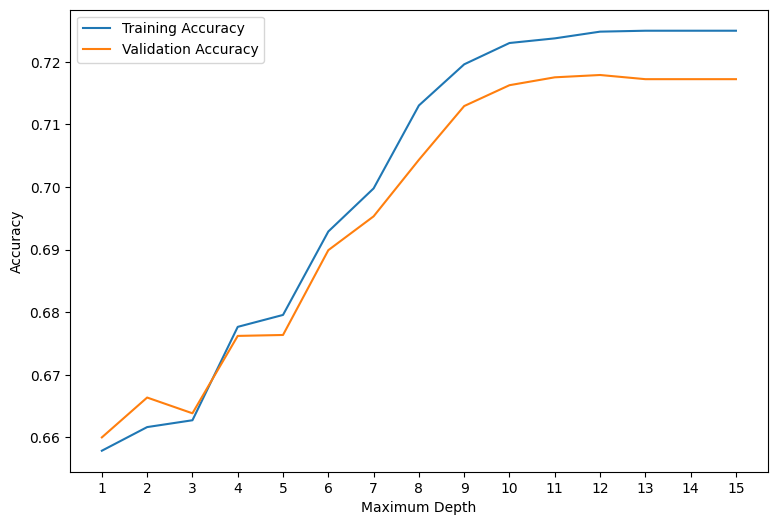

In [22]:
tr_acc = []
va_acc = []
depth_list = range(1,16)

for d in depth_list:
    params = {
    'min_samples_split': [11,12,13],
    'min_samples_leaf': [7, 8, 9, 10],
    'max_leaf_nodes': [190, 191, 192],
    'ccp_alpha' : [3e-5, 4e-5, 5e-5]
    }
    clf = tree.DecisionTreeClassifier(max_depth=d)
    gcv = GridSearchCV(estimator=clf,param_grid=params)
    gcv.fit(X_train,y_train)
    preds = gcv.predict(X_test)
    preds_2 = gcv.predict(X_train)
    tr_acc.append(accuracy_score(y_train, preds_2))
    va_acc.append(accuracy_score(y_test,preds))

plt.figure(figsize=([9, 6]))
plt.plot(depth_list, tr_acc, label='Training Accuracy')
plt.plot(depth_list, va_acc, label='Validation Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_list)
plt.legend()
plt.show()

In [14]:
params = {
    'max_depth': [14, 15, 16],
    'min_samples_split': [11,12,13],
    'min_samples_leaf': [7, 8, 9, 10],
    'max_leaf_nodes': [190, 191, 192],
    'ccp_alpha' : [3e-5, 4e-5, 5e-5]
    }
clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [3e-05, 4e-05, 5e-05],
                         'max_depth': [14, 15, 16],
                         'max_leaf_nodes': [190, 191, 192],
                         'min_samples_leaf': [7, 8, 9, 10],
                         'min_samples_split': [11, 12, 13]})

Train score 0.7249514293644186
Test score 0.7172143280047365
Train Confusion matrix


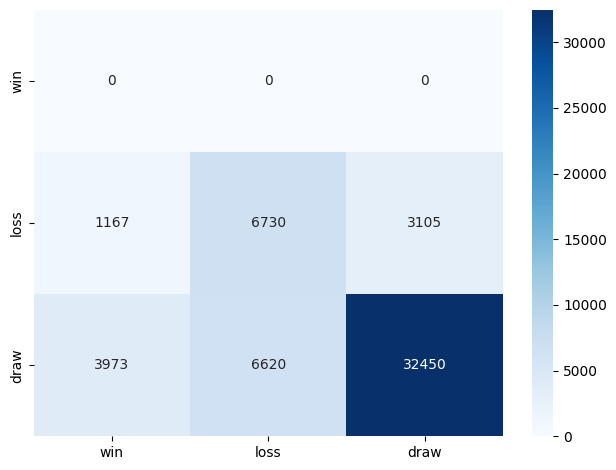

Test Confusion matrix


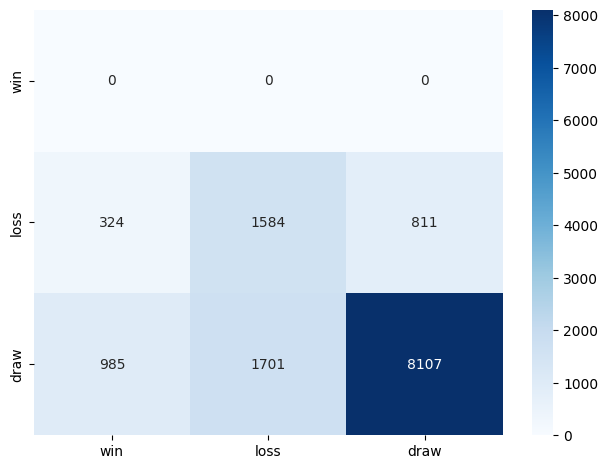

In [18]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
classes = ['win','loss','draw']
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')


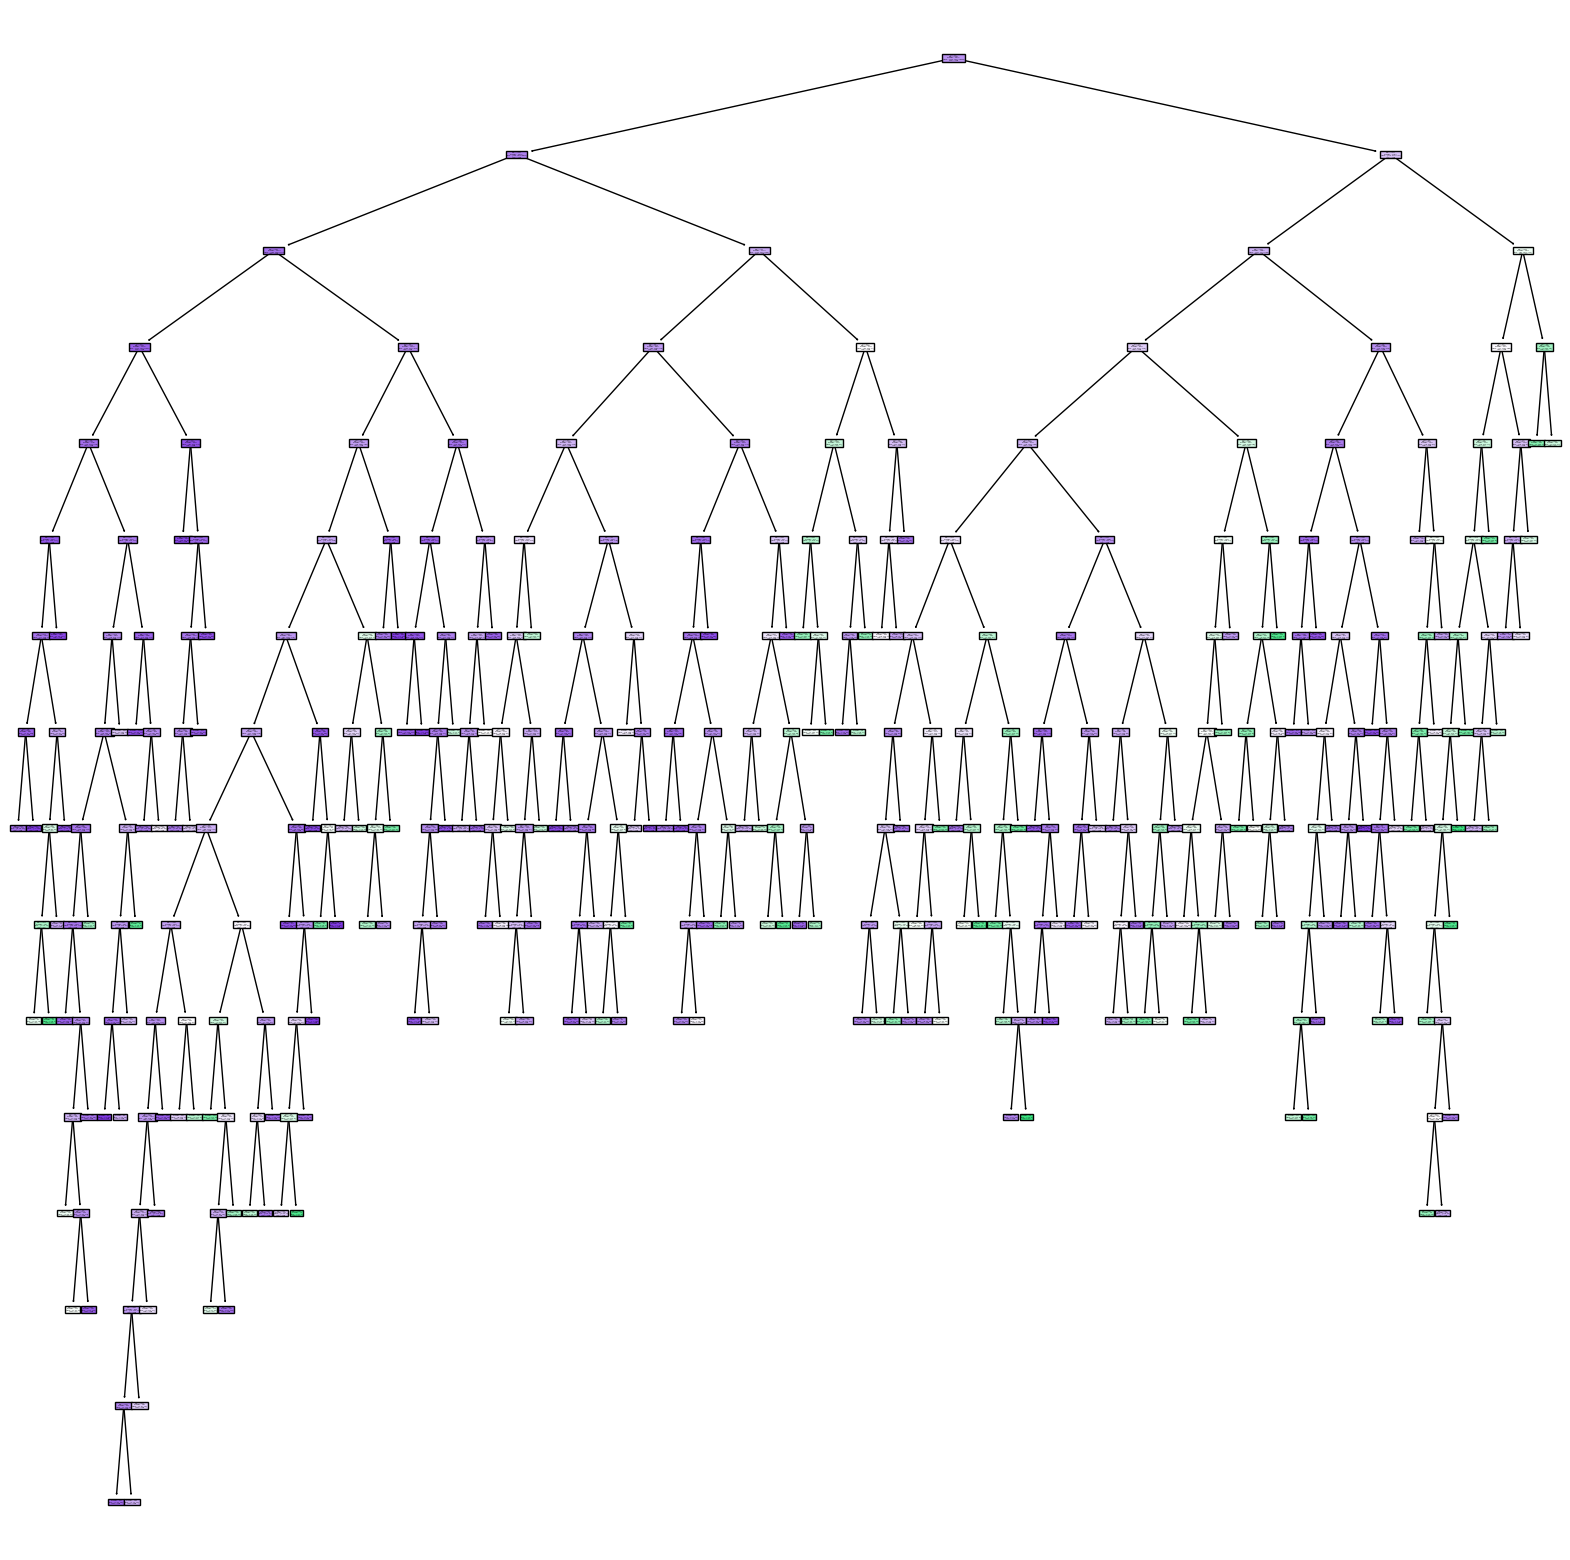

In [19]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['win','loss','draw']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()